# Compute scattering coefficients

Edited by Louise, 28-02-2023

We show how to compute scattering coefficients. Starting with axisymmetric wavelets.


In [114]:
import s2wav.utils.shapes
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

# Parameters
N = 3 is 5 orientations (2*N-1)

In [116]:
sampling = "mw"
L = 32
multiresolution = True
reality = False
N = 3
J_min = 0
nside = L/2

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = False
if N == 1:
    axi = True

5


# Make a data map

(32, 63)


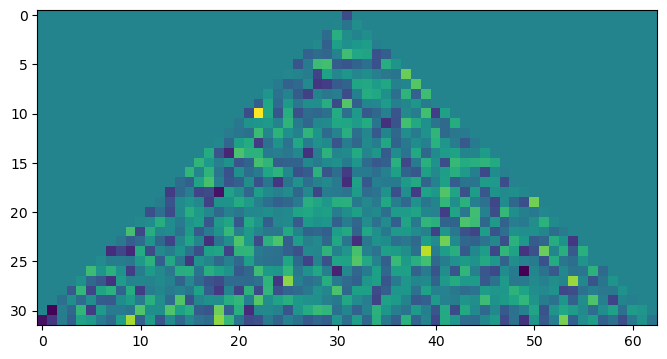

In [117]:
reload(sphlib)
# Random noise
np.random.seed(2)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)
I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)

# Planet image
# I = sphlib.make_hpx_planet(nside=nside, planet='venus', interp=True, normalize=False)
# grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
# I = pil_to_array(grayscale_pil_image)

# SHT forward transform
Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)
print(Ilm.shape)

# Plot the map
# plt.figure(figsize=(8, 6))
# plt.imshow(I)
# hp.mollview(I)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm))

# Build the wavelets

(6, 32, 63)


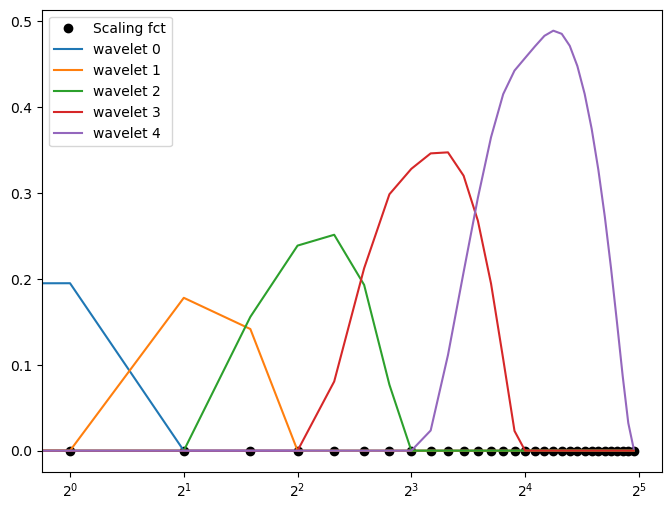

In [118]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)
m = L-1

plt.figure(figsize=(8, 6))
plt.plot(filters[1], 'ko', label='Scaling fct')
for j in range(J):
    plt.plot(np.real(filters[0])[j, :, m], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

# Compute the scattering coefficients

In [136]:
reload(scatlib)
# Compute the coeff
if axi:
    # mean, var, S1, P00, C01, C11 = scatlib.scat_cov_axi(
    #     Ilm[:,L-1:], L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)
    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_axi(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)
else:
    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
    Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)

Text(0.5, 0, 'q scale')

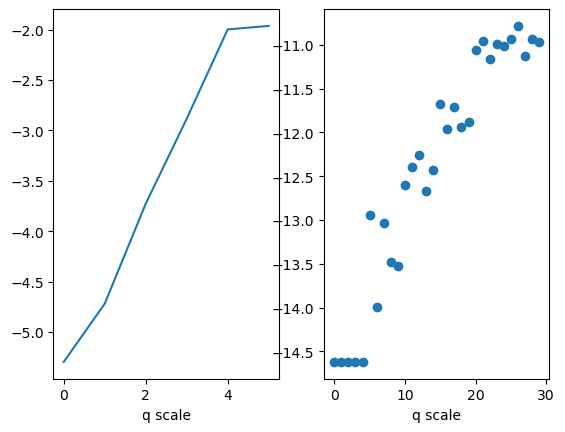

In [137]:
avgS1 = np.average(S1.reshape(-1, 2*N-1), axis=1)
avgP00 = np.average(P00.reshape(-1, 2*N-1), axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.plot(np.log2(S1), 'o')
ax1.plot(np.log2(avgS1))
ax1.set_xlabel('q scale')

ax2.plot(np.log2(P00), 'o')
# ax2.plot( np.log2(avgP00))
ax2.set_xlabel('q scale')

In [138]:
print(C01)

[-1.10030162e-03+6.56506330e-04j -1.10030162e-03+6.56506330e-04j
 -1.10030162e-03+6.56506330e-04j -1.10030162e-03+6.56506330e-04j
 -1.10030162e-03+6.56506330e-04j -4.88380526e-04-5.94593178e-04j
 -4.88380526e-04-5.94593178e-04j -4.88380526e-04-5.94593178e-04j
 -4.88380526e-04-5.94593178e-04j -4.88380526e-04-5.94593178e-04j
 -5.78979753e-04-7.98453121e-05j -5.78979753e-04-7.98453121e-05j
 -5.78979753e-04-7.98453121e-05j -5.78979753e-04-7.98453121e-05j
 -5.78979753e-04-7.98453121e-05j -9.44332426e-04-8.12505068e-05j
 -9.44332426e-04-8.12505068e-05j -9.44332426e-04-8.12505068e-05j
 -9.44332426e-04-8.12505068e-05j -9.44332426e-04-8.12505068e-05j
 -2.93873890e-04-8.68151243e-04j -2.93873890e-04-8.68151243e-04j
 -2.93873890e-04-8.68151243e-04j -2.93873890e-04-8.68151243e-04j
 -2.93873890e-04-8.68151243e-04j -4.66166203e-04-5.89894176e-04j
 -4.66166203e-04-5.89894176e-04j -4.66166203e-04-5.89894176e-04j
 -4.66166203e-04-5.89894176e-04j -4.66166203e-04-5.89894176e-04j
 -6.17218472e-04-8.242315

In [139]:
print(C11)

[ 1.01409281e-04-3.60115114e-21j  1.01409281e-04-3.60115114e-21j
  1.01409281e-04-3.60115114e-21j ... -9.74911250e-05+1.19709540e-12j
  2.31565037e-03+1.39310773e-12j  6.18450901e-04+4.07022354e-12j]


# Check on white noise

In [140]:
# Check that C01 is compatible with 0 for white noise
nreals = 30
S1_all, P00_all, C01_all, C11_all = [], [], [], []
for i in range(nreals):
    print('real:', i)
    I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
    Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)

    if axi:
        mean, var, S1, P00, C01, C11 = scatlib.scat_cov_axi(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)
    else:
        mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)

    print(C01)
    print(C11)
    S1_all.append(S1)
    P00_all.append(P00)
    C01_all.append(C01)
    C11_all.append(C11)

S1_all = np.array(S1_all)
P00_all = np.array(P00_all)
C01_all = np.array(C01_all)
C11_all = np.array(C11_all)

real: 0
[ 3.46440744e-04-8.11142301e-05j  3.46440744e-04-8.11142301e-05j
  3.46440744e-04-8.11142301e-05j  3.46440744e-04-8.11142301e-05j
  3.46440744e-04-8.11142301e-05j -5.40502353e-04-6.00962971e-04j
 -5.40502353e-04-6.00962971e-04j -5.40502353e-04-6.00962971e-04j
 -5.40502353e-04-6.00962971e-04j -5.40502353e-04-6.00962971e-04j
  8.39074715e-04+1.14269881e-04j  8.39074715e-04+1.14269881e-04j
  8.39074715e-04+1.14269881e-04j  8.39074715e-04+1.14269881e-04j
  8.39074715e-04+1.14269881e-04j -9.38878346e-04-6.87757585e-04j
 -9.38878346e-04-6.87757585e-04j -9.38878346e-04-6.87757585e-04j
 -9.38878346e-04-6.87757585e-04j -9.38878346e-04-6.87757585e-04j
  1.05146512e-04-4.19907195e-04j  1.05146512e-04-4.19907195e-04j
  1.05146512e-04-4.19907195e-04j  1.05146512e-04-4.19907195e-04j
  1.05146512e-04-4.19907195e-04j -7.39277040e-05+1.19618408e-04j
 -7.39277040e-05+1.19618408e-04j -7.39277040e-05+1.19618408e-04j
 -7.39277040e-05+1.19618408e-04j -7.39277040e-05+1.19618408e-04j
  1.22456495e-03-

In [141]:
# Normalize by the STD over realisations
stdS1 = np.std(S1_all, axis=0)
stdP00 = np.std(P00_all, axis=0)
stdC01 = np.std(C01_all, axis=0)
stdC11 = np.std(C11_all, axis=0)

avgS1 = np.mean(S1_all, axis=0)
avgP00 = np.mean(P00_all, axis=0)
avgC01 = np.mean(C01_all, axis=0)
avgC11 = np.mean(C11_all, axis=0)

In [142]:
stdC11.shape


(2500,)

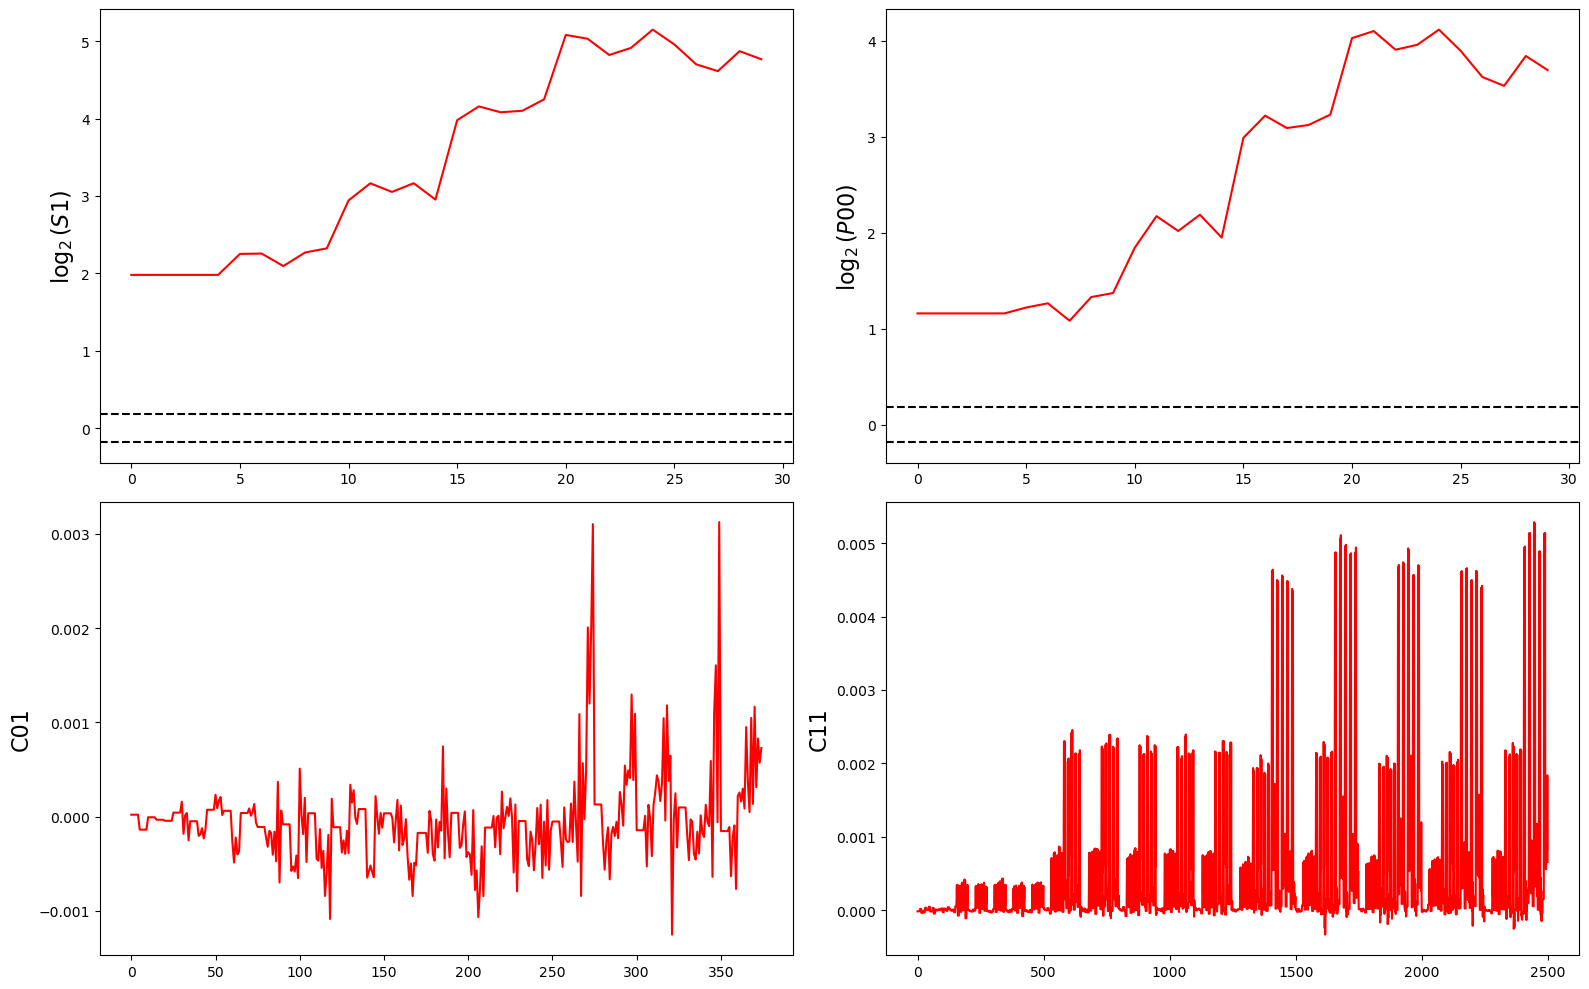

In [143]:
def forplot(ax):
    # ax.legend(fontsize=16)
    ax.axhline(-1/np.sqrt(nreals), color='k', ls='--')
    ax.axhline(1/np.sqrt(nreals), color='k', ls='--')
    return

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(np.log2(avgS1 / stdS1), 'r')
axs[0].set_ylabel(r'$\log_2(S1)$', fontsize=16)
forplot(axs[0])

axs[1].plot(np.log2(avgP00 / stdP00), 'r')
axs[1].set_ylabel(r'$\log_2(P00)$', fontsize=16)
forplot(axs[1])

axs[2].plot(avgC01, 'r')
axs[2].set_ylabel('C01', fontsize=16)
# forplot(axs[2])
# axs[2].set_yscale('log')

axs[3].plot(avgC11, 'r')
axs[3].set_ylabel('C11', fontsize=16)
# forplot(axs[3])
# axs[3].set_yscale('log')

fig.tight_layout()

In [144]:
print(C11[:])

[-9.15744707e-05+8.83892392e-21j -9.15744707e-05+8.83892392e-21j
 -9.15744707e-05+8.83892392e-21j ...  1.46944530e-04-4.27005649e-13j
  2.08786748e-03+1.39721531e-11j -5.98486284e-05-7.50424319e-12j]


In [145]:
print(C01[:100])

[ 1.08629153e-04+5.81116067e-04j  1.08629153e-04+5.81116067e-04j
  1.08629153e-04+5.81116067e-04j  1.08629153e-04+5.81116067e-04j
  1.08629153e-04+5.81116067e-04j -2.73034384e-04-2.72391001e-04j
 -2.73034384e-04-2.72391001e-04j -2.73034384e-04-2.72391001e-04j
 -2.73034384e-04-2.72391001e-04j -2.73034384e-04-2.72391001e-04j
  2.15033141e-04+5.61647419e-04j  2.15033141e-04+5.61647419e-04j
  2.15033141e-04+5.61647419e-04j  2.15033141e-04+5.61647419e-04j
  2.15033141e-04+5.61647419e-04j -7.25687032e-06+2.95960442e-04j
 -7.25687032e-06+2.95960442e-04j -7.25687032e-06+2.95960442e-04j
 -7.25687032e-06+2.95960442e-04j -7.25687032e-06+2.95960442e-04j
 -2.14828608e-04+8.75386635e-05j -2.14828608e-04+8.75386635e-05j
 -2.14828608e-04+8.75386635e-05j -2.14828608e-04+8.75386635e-05j
 -2.14828608e-04+8.75386635e-05j -3.49515433e-04-7.10350504e-04j
 -3.49515433e-04-7.10350504e-04j -3.49515433e-04-7.10350504e-04j
 -3.49515433e-04-7.10350504e-04j -3.49515433e-04-7.10350504e-04j
 -1.23230704e-04+1.150363

In [112]:
multiresolution=True
filters_out = filters_directional_vectorised(L, N, J_min)
for j in range(J_min, J_min+1):
    Lj, Nj, _ = s2wav.utils.shapes.LN_j(L, j, N, multiresolution=multiresolution)
    print(L, Lj)

    filters_in = filters_directional_vectorised(Lj, Nj, J_min)

    filters_sliced = (filters_out[0][:j-J_min+1, :Lj, L-Lj:L-1+Lj], filters[1])

    print('Out', filters_out[0].shape)
    print('Sliced', filters_sliced[0].shape)
    print('In', filters_in[0].shape)

    # for n in range(2*Nj-1):


32 4
Out (6, 32, 63)
Sliced (1, 4, 7)
In (3, 4, 7)


In [102]:
    #     M_lm = np.random.randn(32, 63)
    #
    #     val, _ = s2wav.flm_to_analysis(
    #                     M_lm,
    #                     Lj,
    #                     Nj,
    #                     J_min,
    #                     sampling=sampling,
    #                     nside=nside,
    #                     reality=reality,
    #                     multiresolution=multiresolution,
    #                     filters=filters[0][:j-J_min+1][:Lj, L-Lj:L-1+Lj], filters[1])


[Array([[[-0.2600533 +0.j        , -0.21394035+0.06534699j,
          -0.1103255 +0.08148637j, -0.02723285+0.03626485j,
          -0.02723285-0.03626485j, -0.1103255 -0.08148637j,
          -0.21394035-0.06534699j],
         [-0.30917711+0.j        , -0.20556226+0.14683336j,
           0.02725819+0.18309821j,  0.21396569+0.08148637j,
           0.21396569-0.08148637j,  0.02725819-0.18309821j,
          -0.20556226-0.14683336j],
         [-0.12548425+0.j        , -0.0423916 +0.11775121j,
           0.14431591+0.14683336j,  0.2940437 +0.06534699j,
           0.2940437 -0.06534699j,  0.14431591-0.14683336j,
          -0.0423916 -0.11775121j],
         [ 0.15270081-0.j        ,  0.15270081-0.j        ,
           0.15270081-0.j        ,  0.15270081-0.j        ,
           0.15270081-0.j        ,  0.15270081-0.j        ,
           0.15270081-0.j        ]],
 
        [[-0.2600533 -0.j        , -0.21394035+0.06534699j,
          -0.1103255 +0.08148637j, -0.02723285+0.03626485j,
          -0.